In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pickle import load
import seaborn as sns
import models.plot as mpl
import models.testset as ts
import itertools as it
import pandas as pd

Files already downloaded and verified
Files already downloaded and verified


In [2]:
def pload(fn):
    with open(fn, 'rb') as f:
        return load(f)

In [3]:
testset_choosing = pload('./Testset_Choosing_Org.txt')

In [4]:
Ideal_reference = pload('./Reference_result.txt')

In [5]:
for n in ts.Names:
    try:
        testset_choosing['result'][n]['Ideal'] = max(Ideal_reference['prec'][n])
    except:
        pass

In [6]:
def subplots(nr, nc, unit_size=4):
    try:
        fig = plt.figure(figsize=(nc * unit_size[0], nr * unit_size[1]))
    except:
        fig = plt.figure(figsize=(nc * unit_size, nr * unit_size))
    return fig

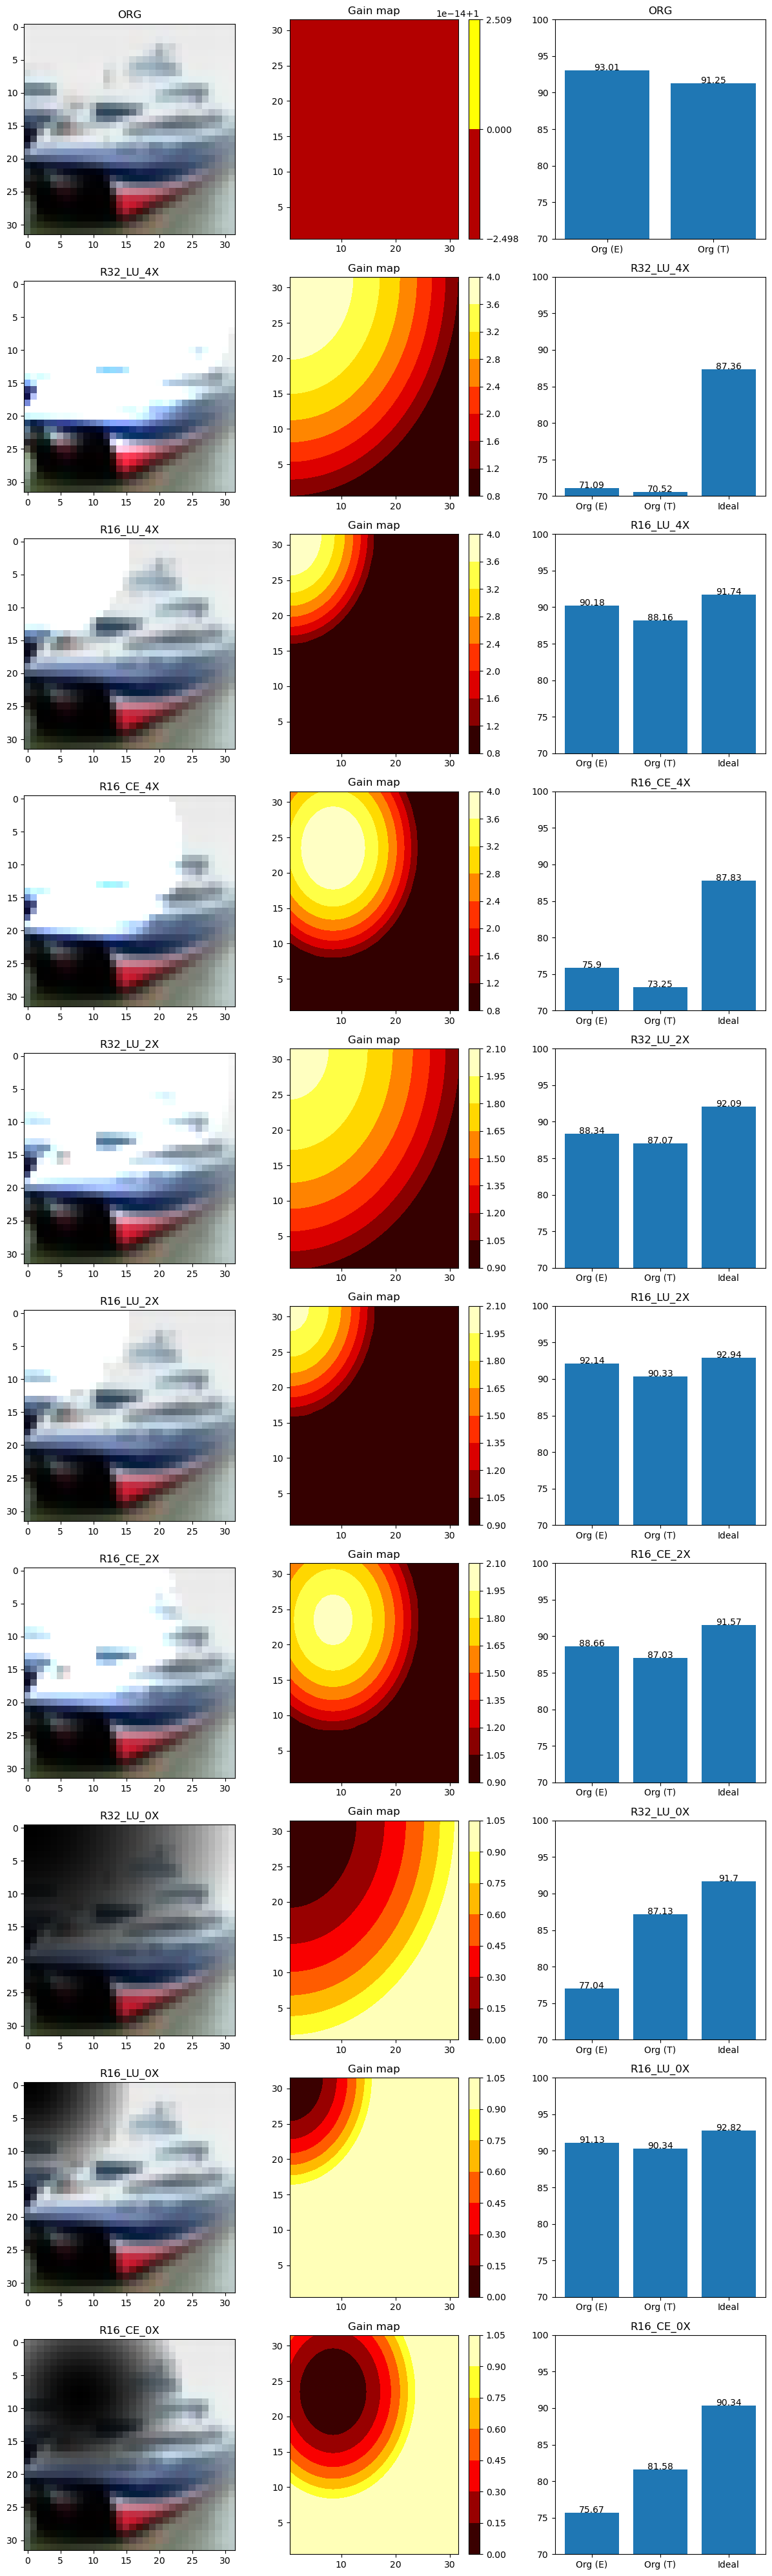

In [7]:
data = testset_choosing['result']
nr = len(data)
nc = 3
fig = subplots(nr, nc)
for i, n in enumerate(ts.Names):
    ax = plt.subplot(nr, nc, i * 3 + 1)
    imit = iter(torch.utils.data.DataLoader(ts.test_ds_im_sets[n], batch_size=ts.batch_size, shuffle=False))
    d, _ = next(imit)
    dp = np.array(d[1])
    plt.imshow(dp)
    plt.title(n)
    
    ax = plt.subplot(nr, nc, i * 3 + 2)
    plt.contourf(ts.rtrs[n].map[0][:, :, 0], origin='upper', cmap='hot')
    plt.colorbar()
    plt.title('Gain map')
    
    ax = plt.subplot(nr, nc, i * 3 + 3)
    plt.bar(data[n].keys(), data[n].values())
    plt.title(n)
    plt.ylim([70,100])
    mpl.addlabels(plt, list(data[n].keys()), list(data[n].values()))

fig.tight_layout()
    

In [8]:
IncParamSweep = pload('./Incremental_Parameter_Sweep.txt')['result']

In [9]:
lr = [4e-3, 2e-3, 4e-4]
epochs = [5, 10, 20, 100, 200]
nhist = [1, 3, 5, 10]
IncParamSweep.update(testset_choosing['result']['R32_LU_4X'])


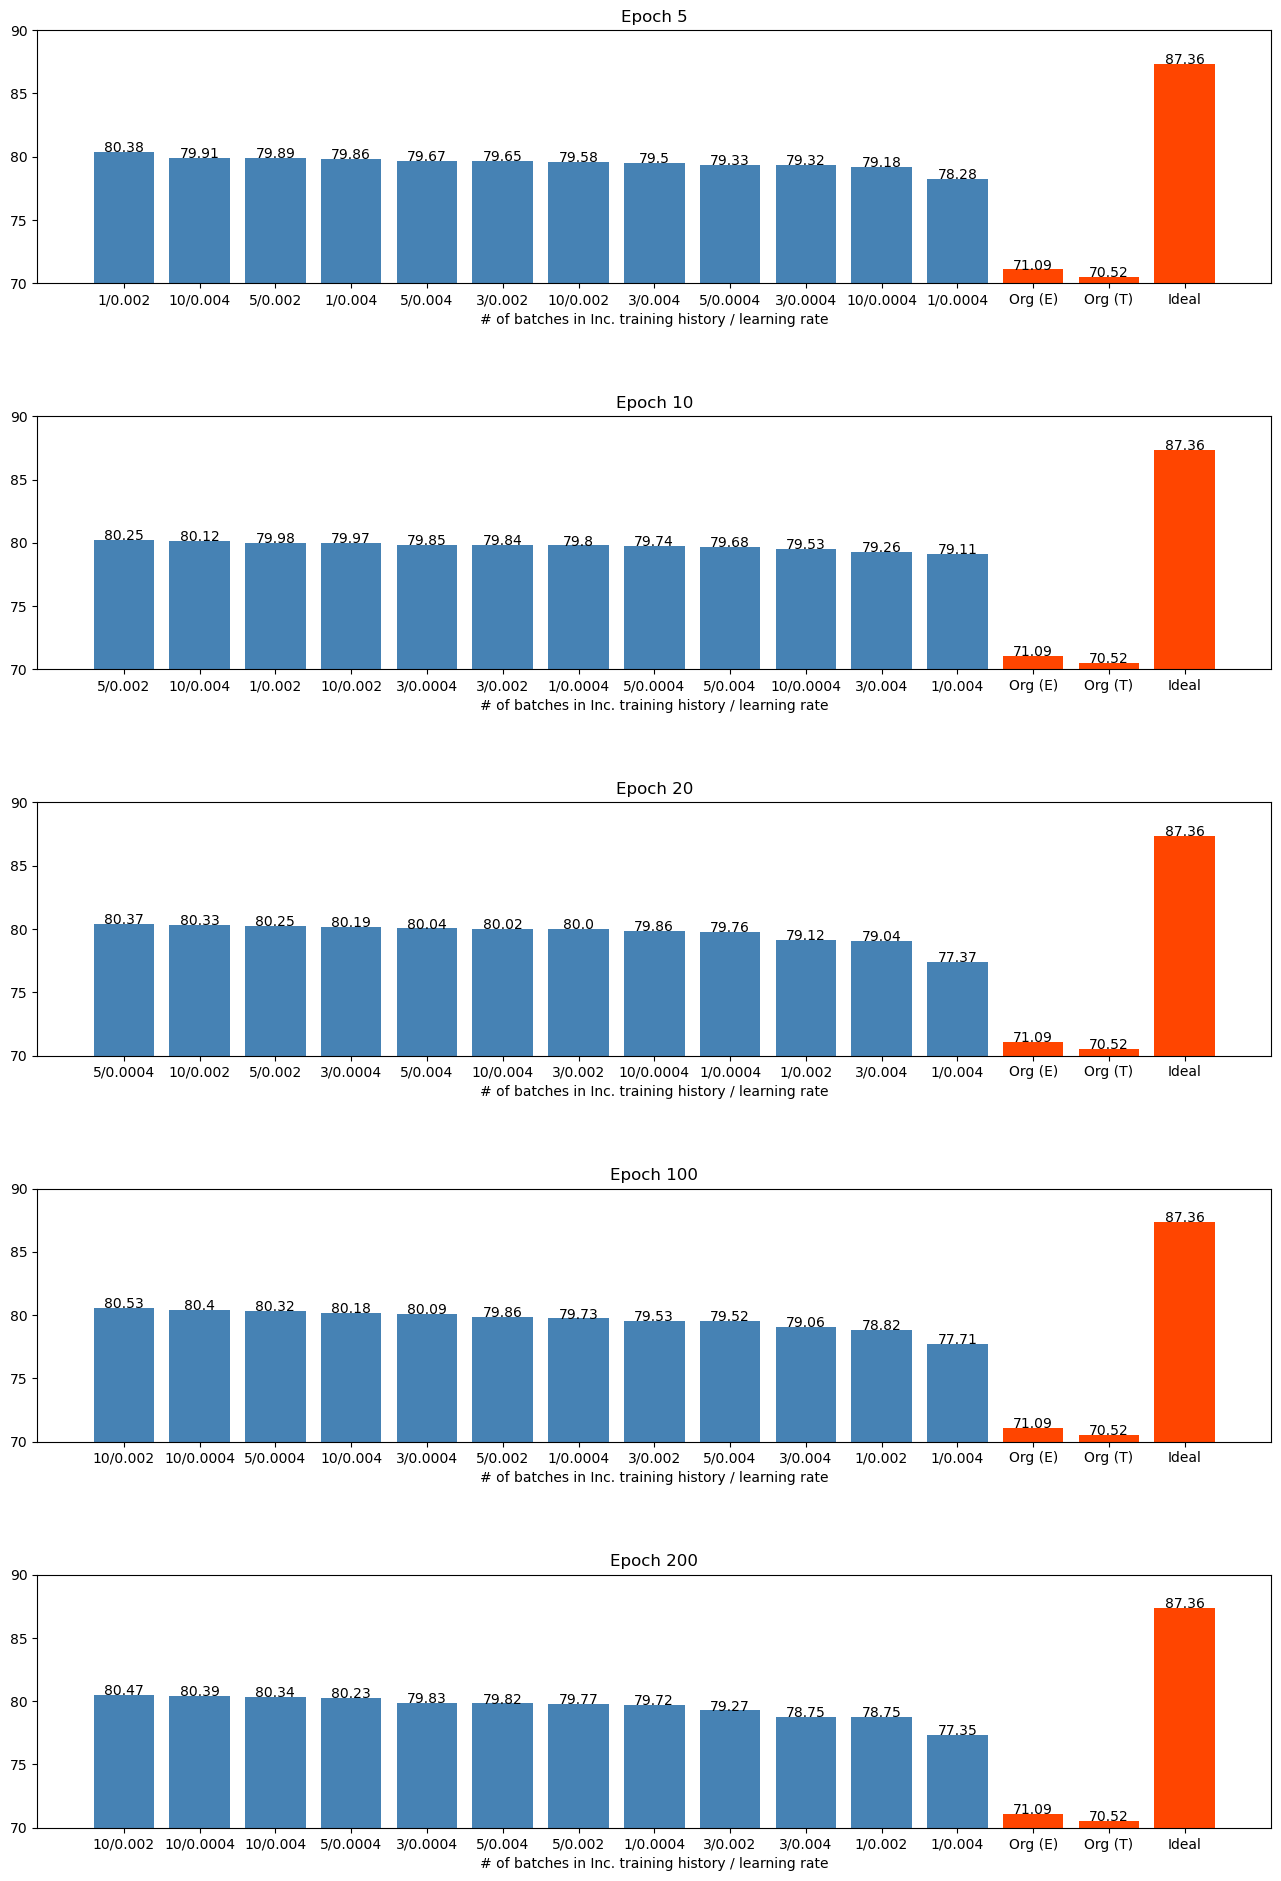

In [10]:
fig = subplots(len(epochs), 1, (14, 4))
IncParamSweepSorted = {}
for i, e in enumerate(epochs):
    plt.subplot(len(epochs), 1, i + 1)
    data = {f'{h}/{l}': IncParamSweep[f'I {l}/{e}/{h}/M'][0] for l, h in it.product(lr, nhist)}
    sorted_t = sorted(data.items(), key=lambda x: x[1], reverse=True)
    sorted_data = dict(sorted_t)
    color = ['steelblue'] * len(sorted_data)
    sorted_data.update(testset_choosing['result']['R32_LU_4X'])
    color += ['orangered'] * 3
    plt.bar(sorted_data.keys(), sorted_data.values(), color=color)
    mpl.addlabels(plt, list(sorted_data.keys()), list(sorted_data.values()))
    plt.title(f'Epoch {e}')
    plt.xlabel('# of batches in Inc. training history / learning rate')
    plt.ylim([70, 90])
    plt.yticks(ticks=range(70, 91, 5))
    IncParamSweepSorted[e] = {'Incremental': sorted_t[0][1]}
    IncParamSweepSorted[e].update(testset_choosing['result']['R32_LU_4X'])
    
fig.tight_layout(pad=5.0)

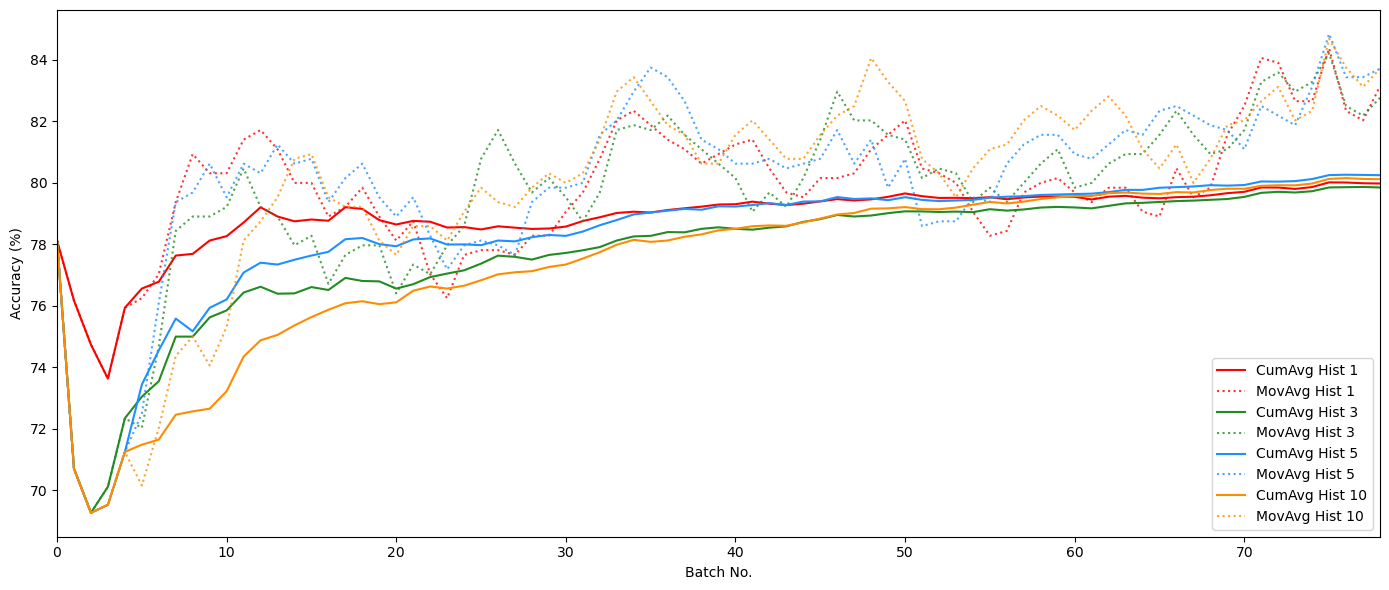

In [58]:
targets = [(1, 0.002), (3, 0.0004), (5, 0.002), (10, 0.004)]
def moving_avg(data, win=5):
    precs = np.array([data[x][0] for x in range(len(data))])
    cnts = np.array([data[x][2] for x in range(len(data))])
    precsc = precs * cnts
    cumprecs = np.cumsum(precsc)
    cumcnts = np.cumsum(cnts)
    cumavg = cumprecs / cumcnts
    movavg = (cumprecs - np.pad(cumprecs, (win, 0))[:-win]) / (cumcnts - np.pad(cumcnts, (win, 0))[:-win])
    return cumavg, movavg
fig = subplots(1, 1, (14, 6))
    
data = {f'{x[0]}': IncParamSweep[f'I {x[1]}/10/{x[0]}/M'] for x in targets}
colors = ['red', 'forestgreen', 'dodgerblue', 'darkorange']
lcolors = ['lightcoral', 'lightgreen', 'powderblue', 'moccasin']
rdata = {}
for k, v in data.items():
    cumavg, movavg = moving_avg(v[1], 5)
    cur = {'name': k,
           'overall': v[0],
           'avgb': [v[1][x][0] for x in range(len(v[1]))],
           'cumavg': cumavg,
           'movavg': movavg}
    rdata[k] = cur

plt.subplot(1, 1, 1)
for i, (k, v) in enumerate(rdata.items()):
    plt.plot(v['cumavg'], color=colors[i], linestyle='solid', label=f'CumAvg Hist {k}')
    plt.plot(v['movavg'], color=colors[i], linestyle=':', alpha=0.8, label=f'MovAvg Hist {k}')


plt.xlabel('Batch No.')
plt.ylabel('Accuracy (%)')
plt.xlim([0, 78])
plt.legend()
fig.tight_layout()
    

In [11]:
re_training = pload('Incremental_Training_Testset.txt')

In [12]:
data = {x: re_training['test_result'][x][0] for x in re_training['test_result']}
lr = [4e-2, 4e-3, 2e-3, 4e-4]
epochs = [1, 10, 100, 300]
nhist = [3, 10, 100, 400]
rdf = pd.DataFrame([{'lr': l, 'epoch': e, 'nhist': h, 'prec': data[f'I {l}/{e}/{h}/M']} for l, e, h in it.product(lr, epochs, nhist)])
rdf.loc[rdf['nhist'] == 400, 'nhist'] = 'All'


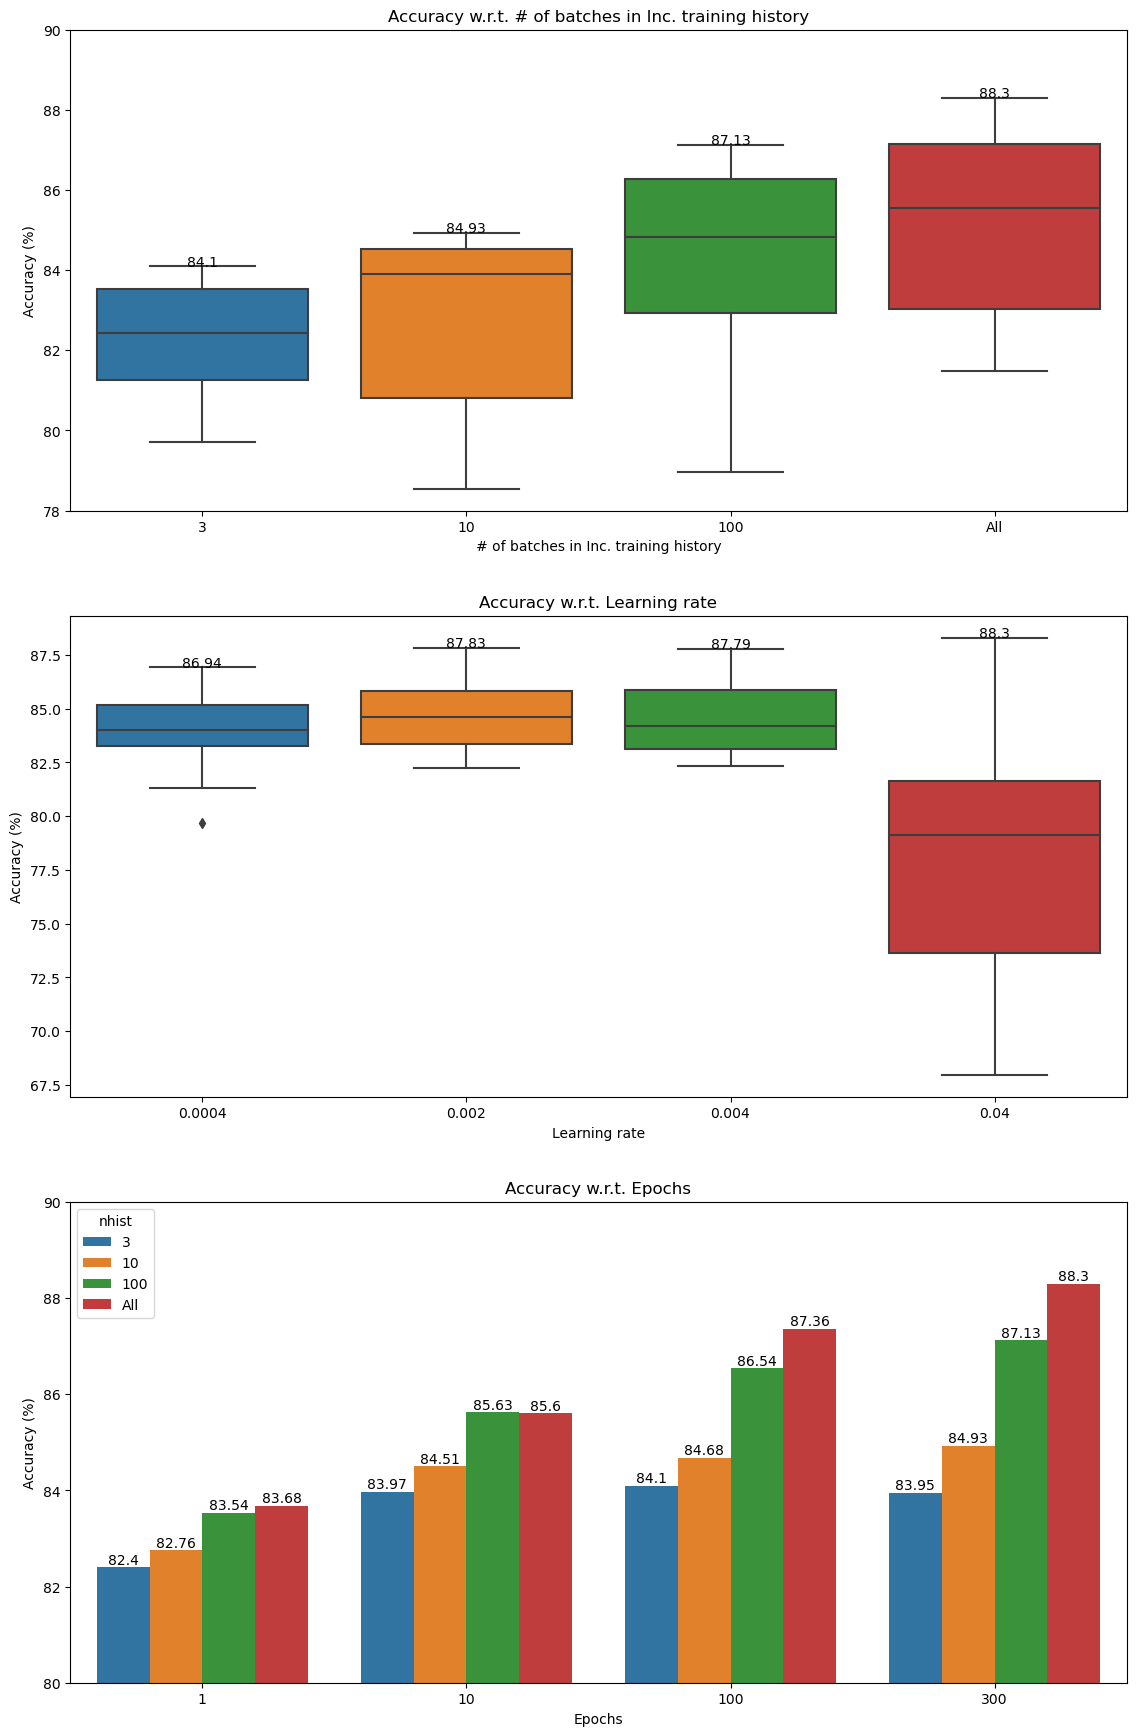

In [13]:
fig = subplots(3, 1, (12, 6))
plt.subplot(3, 1, 1)
sns.boxplot(data=rdf, x='nhist', y='prec')
mpl.addlabels(plt, nhist, rdf.groupby('nhist').max('prec')['prec'].values)
plt.xlabel('# of batches in Inc. training history')
plt.ylabel('Accuracy (%)')
plt.ylim([78, 90])
plt.title('Accuracy w.r.t. # of batches in Inc. training history')

plt.subplot(3, 1, 2)
sns.boxplot(data=rdf, x='lr', y='prec')
mpl.addlabels(plt, lr, rdf.groupby('lr').max('prec')['prec'].values)
plt.ylabel('Accuracy (%)')
plt.xlabel('Learning rate')
plt.title('Accuracy w.r.t. Learning rate')

plt.subplot(3, 1, 3)
ax = sns.barplot(data=rdf.groupby(['epoch', 'nhist'], as_index=False).max('prec'), x='epoch', y='prec', hue='nhist')
for i in ax.containers:
    ax.bar_label(i, )
plt.ylim([75, 90])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim([80,90])
plt.title('Accuracy w.r.t. Epochs')

fig.tight_layout(pad=3)

In [15]:
QuantMax = pload('./Quant_Incremental_Parameter_Sweep_Max.txt')['result']
QuantMean = pload('./Quant_Incremental_Parameter_Sweep_Mean.txt')['result']

In [16]:
QuantMax = {x: QuantMax[x][0] for x in QuantMax}
QuantMean = {x: QuantMean[x][0] for x in QuantMean}

In [17]:
Quant = dict()
Quant.update(QuantMax)
Quant.update(QuantMean)

In [18]:
import fnmatch as fm
import pandas as pd
epochs = [5, 10, 20, 100, 200]
fbits = [2, 3, 4]
gbits = [2, 3, 4, 5, 6, 7]
cl = {'Mean': lambda x: x.abs().mean(), '2xMean': lambda x: x.abs().mean() * 2, '3xMean': lambda x: x.abs().mean() * 3,
      'Max/4': lambda x: x.abs().max() / 4, 'Max/2': lambda x: x.abs().max(), '.75Max': lambda x: x.abs().max() * 0.75, 'Max': lambda x: x.abs().max()} 

data = [{'xb': f, 'wb': f, 'gb': g, 'clamp': c, 'epoch': e, 'prec': Quant[f'{f}/{g}/{c}/{e}']} for f, g, c, e in it.product(fbits, gbits, cl, epochs)]

In [19]:
df = pd.DataFrame(data)

In [20]:
df

,xb,wb,gb,clamp,epoch,prec
0,2,2,2,Mean,5,76.21
1,2,2,2,Mean,10,76.97
2,2,2,2,Mean,20,76.58
3,2,2,2,Mean,100,76.35
4,2,2,2,Mean,200,76.57
...,...,...,...,...,...,...
625,4,4,7,Max,5,79.28
626,4,4,7,Max,10,80.28
627,4,4,7,Max,20,79.89
628,4,4,7,Max,100,79.72


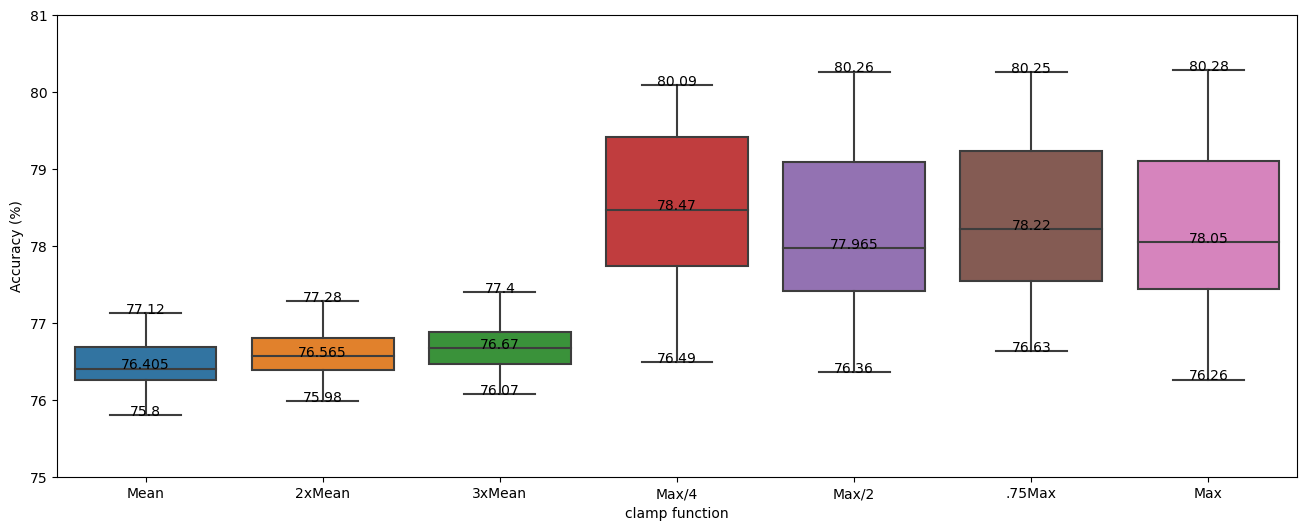

In [21]:
fig = subplots(1, 1, (16, 6))

sns.boxplot(data=df, x='clamp', y='prec')
plt.ylabel('Accuracy (%)')
plt.xlabel('clamp function')
plt.ylim([75, 81])
mpl.addlabels(plt, list(cl.keys()), df.groupby('clamp').max('prec').loc[list(cl.keys()), 'prec'])
mpl.addlabels(plt, list(cl.keys()), df.groupby('clamp').min('prec').loc[list(cl.keys()), 'prec'])
mpl.addlabels(plt, list(cl.keys()), df.groupby('clamp').median('prec').loc[list(cl.keys()), 'prec'])

In [22]:
clmax = list({'Max/4': lambda x: x.abs().max() / 4, 'Max/2': lambda x: x.abs().max(), '.75Max': lambda x: x.abs().max() * 0.75, 'Max': lambda x: x.abs().max()}.keys())
cldf = df[df['clamp'].isin(clmax)]


<AxesSubplot:xlabel='gb', ylabel='prec'>

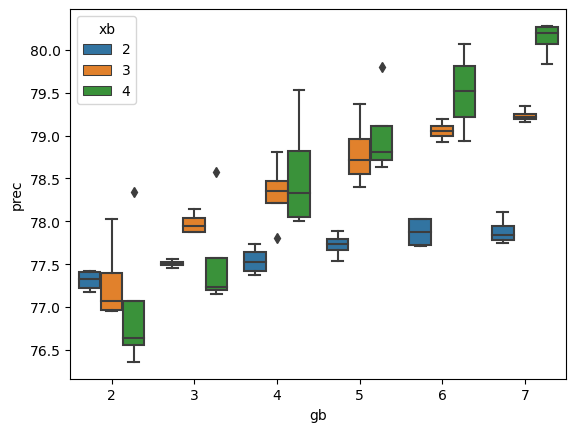

In [23]:
sns.boxplot(data=cldf[cldf['epoch'].isin([10])], x='gb', y='prec', hue='xb')

In [24]:
tdf = cldf[(cldf['xb'] == 4) & (cldf['clamp'] == 'Max/4') & (cldf['epoch'] == 5)]

In [25]:
{f'Q {x[1]["gb"]}bits / {x[1]["clamp"]}': x[1]["prec"] for x in tdf.iterrows()}

{'Q 2bits / Max/4': 78.21,
 'Q 3bits / Max/4': 78.11,
 'Q 4bits / Max/4': 78.57,
 'Q 5bits / Max/4': 78.76,
 'Q 6bits / Max/4': 78.59,
 'Q 7bits / Max/4': 78.66}

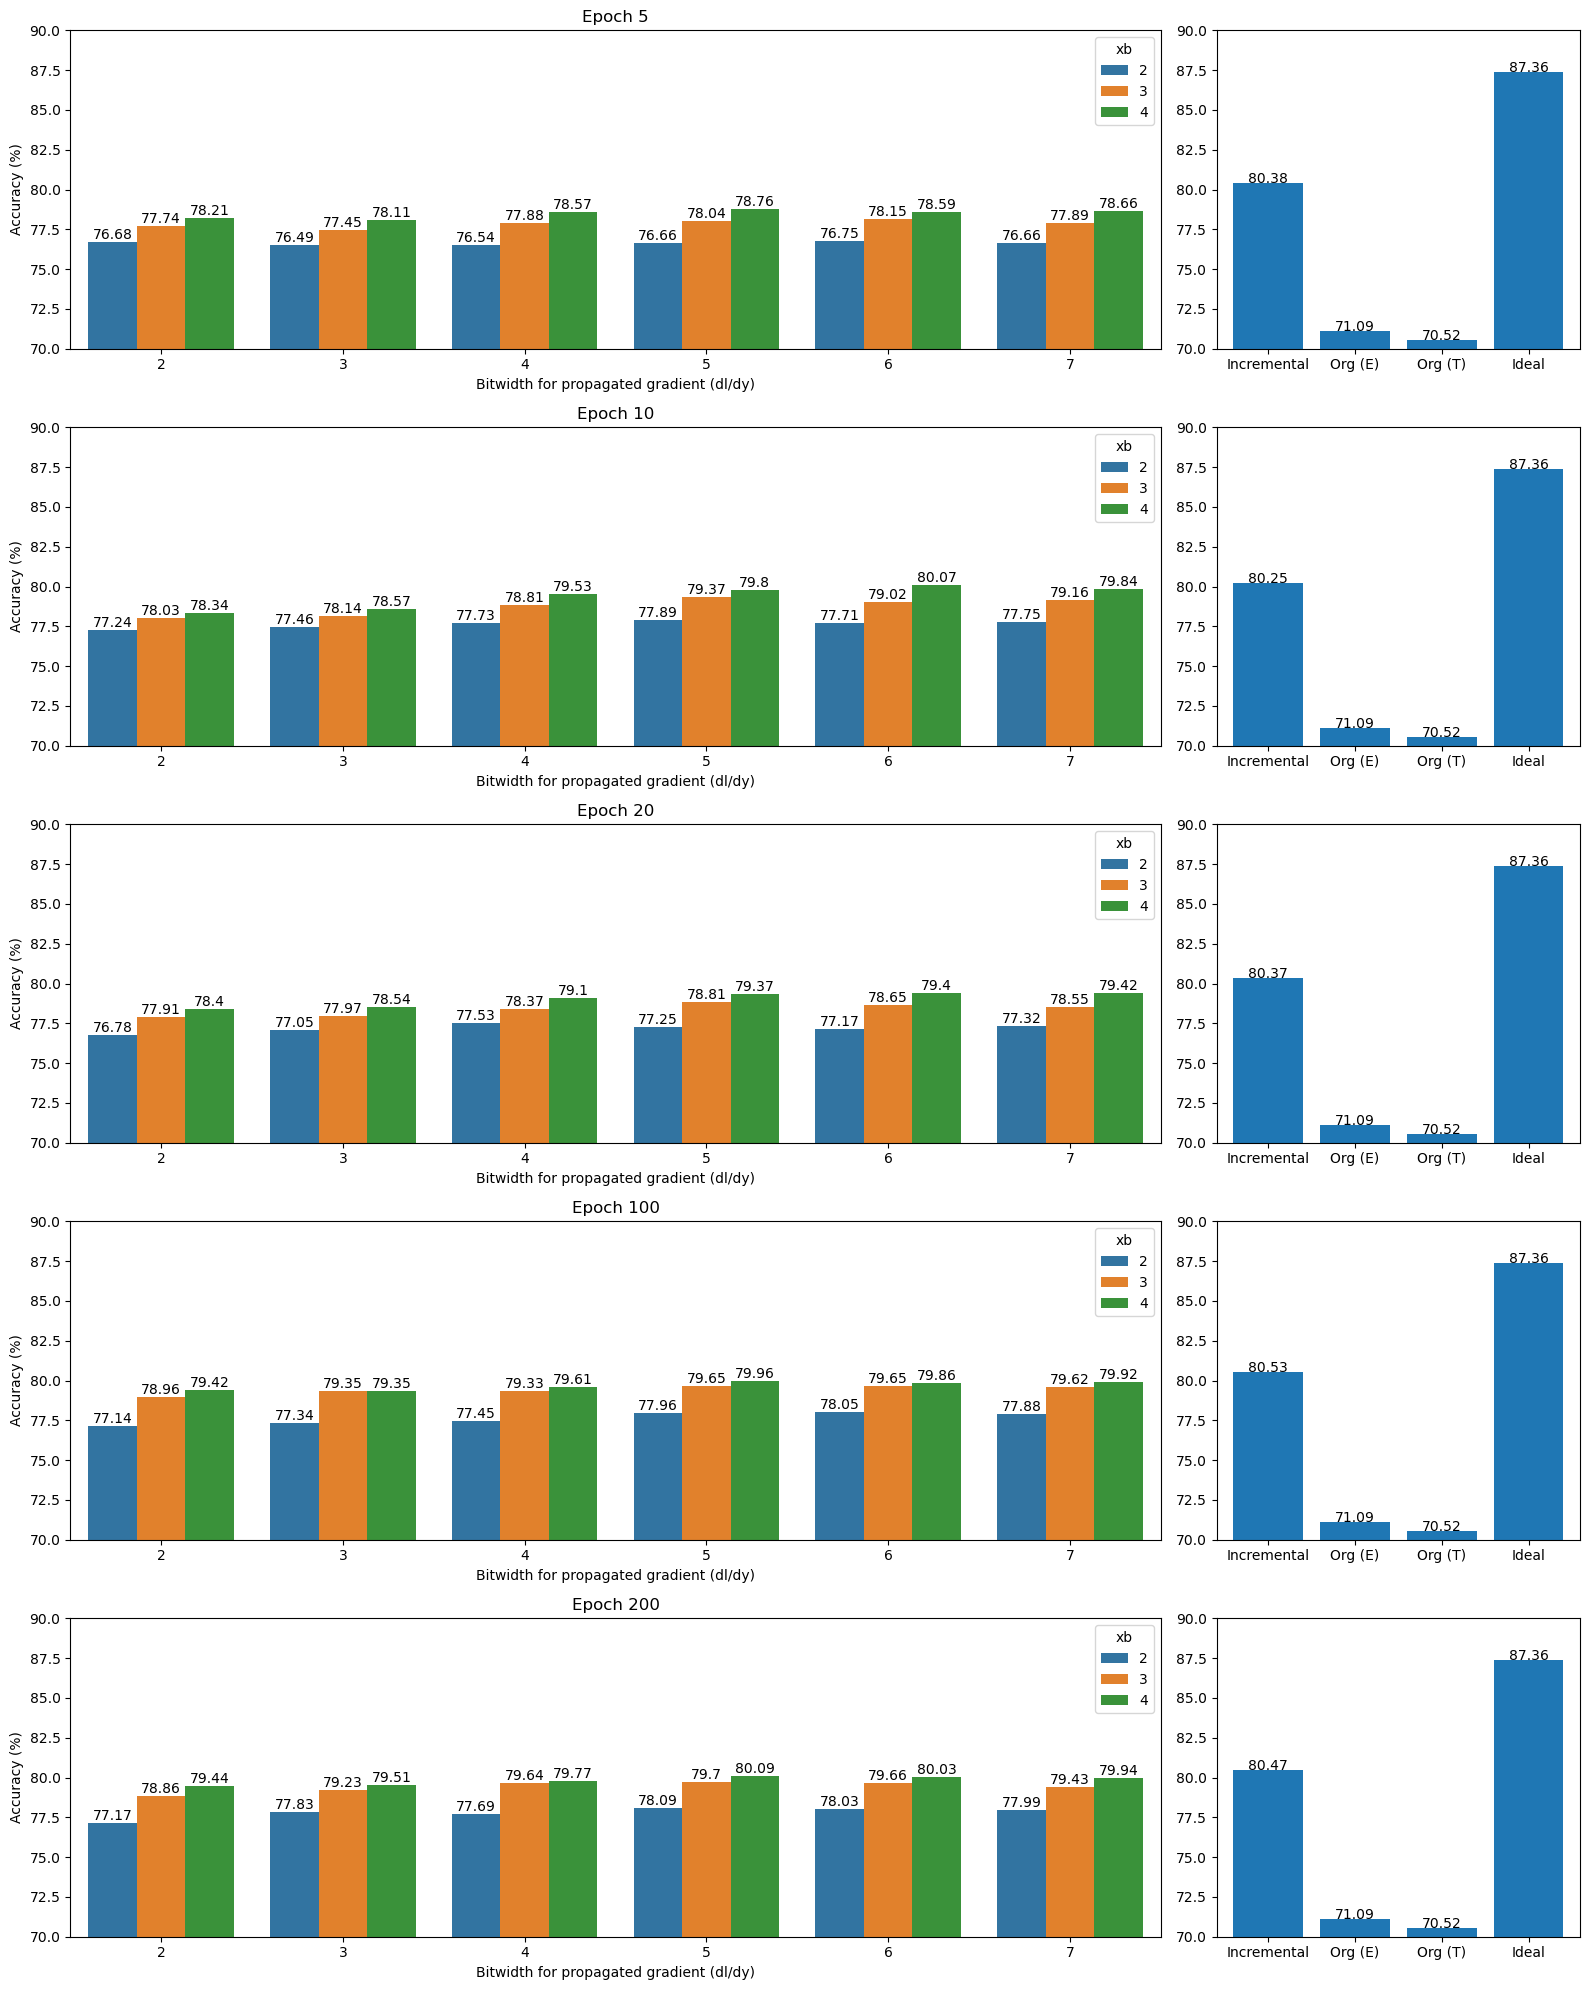

In [26]:
fig, axs = plt.subplots(len(epochs), 2, gridspec_kw={'width_ratios': (3, 1)}, figsize=(16, 4 * len(epochs)))
for i, e in enumerate(epochs):
    plt.subplot(len(epochs), 2, i * 2 + 1)
    tdf = cldf[(cldf['clamp'] == 'Max/4') & (cldf['epoch'] == e)]
    ax = sns.barplot(data=tdf, x='gb', y='prec', hue='xb')
    for j in ax.containers:
        ax.bar_label(j, )
    plt.ylim([70, 90])
    plt.xlabel('Bitwidth for propagated gradient (dl/dy)')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Epoch {e}')

    plt.subplot(len(epochs), 2, i * 2 + 2)
    plt.bar(IncParamSweepSorted[e].keys(), IncParamSweepSorted[e].values())
    plt.ylim([70, 90])
    mpl.addlabels(plt, list(IncParamSweepSorted[e].keys()), list(IncParamSweepSorted[e].values()))
fig.tight_layout()

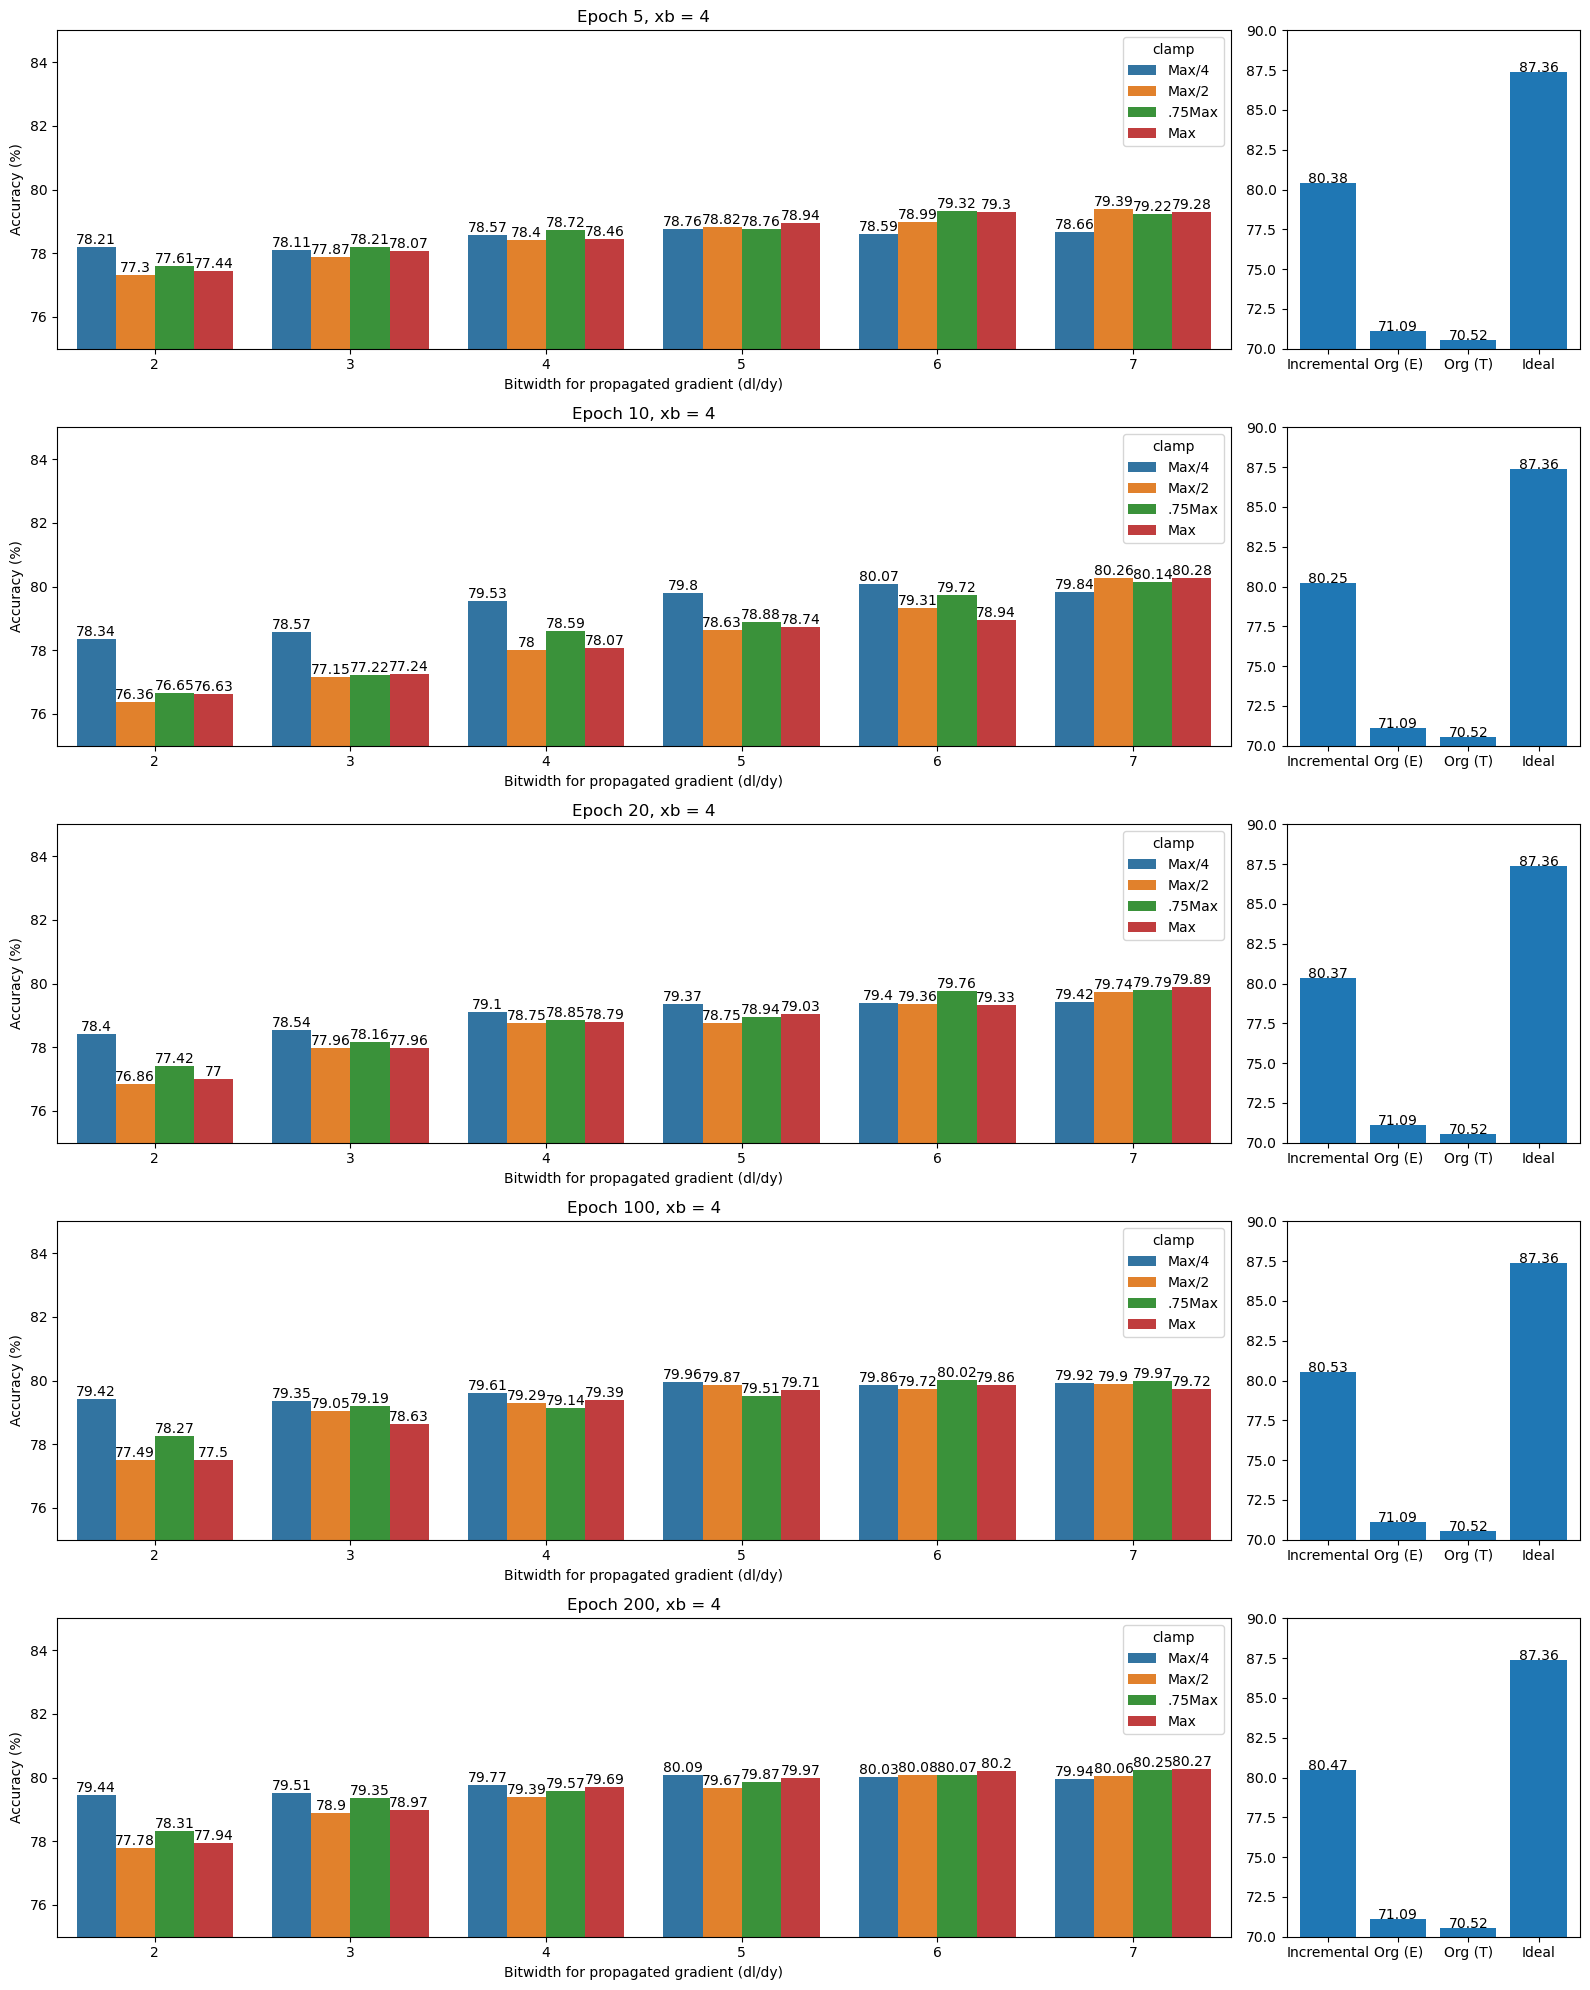

In [35]:
fig, axs = plt.subplots(len(epochs), 2, gridspec_kw={'width_ratios': (4, 1)}, figsize=(16, 4 * len(epochs)))
for i, e in enumerate(epochs):
    plt.subplot(len(epochs), 2, i * 2 + 1)
    tdf = cldf[(cldf['xb'] == 4) & (cldf['epoch'] == e)]
    ax = sns.barplot(data=tdf, x='gb', y='prec', hue='clamp')
    for j in ax.containers:
        ax.bar_label(j, )
    plt.ylim([75, 85])
    plt.xlabel('Bitwidth for propagated gradient (dl/dy)')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Epoch {e}, xb = 4')

    plt.subplot(len(epochs), 2, i * 2 + 2)
    plt.bar(IncParamSweepSorted[e].keys(), IncParamSweepSorted[e].values())
    plt.ylim([70, 90])
    mpl.addlabels(plt, list(IncParamSweepSorted[e].keys()), list(IncParamSweepSorted[e].values()))
fig.tight_layout()